In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
import pandas as pd

file_dir = "/data03/sunyi/time_constrained_cot/outputs/2_6"
model_list = [
    "Qwen/Qwen2.5-72B-Instruct",
    "meta-llama/Llama-3.1-70B-Instruct"
]

PROMP_LIST = [ "-c2f", "-sbs", "-aav", "-sbs-hard", "-c2f-hard", "-aav-hard"]

In [2]:
MODEL_SERIES_MAP = {
    "NovaSky-AI/Sky-T1-32B-Preview": "qwen",
    "Qwen/QwQ-32B-Preview": "qwen",
    "Qwen/Qwen2.5-72B-Instruct": "qwen",
    "Qwen/Qwen2.5-32B-Instruct": "qwen",
    "Qwen/Qwen2.5-14B-Instruct": "qwen",
    "Qwen/Qwen2.5-7B-Instruct": "qwen",
    "Qwen/Qwen2.5-3B-Instruct": "qwen",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen",
    "Qwen/Qwen2.5-Math-1.5B-Instruct": "qwen-math",
    "Qwen/Qwen2.5-Math-7B-Instruct": "qwen-math",
    
    "google/gemma-2-2b-it": "gemma",
    "google/gemma-2-9b-it": "gemma",
    "google/gemma-2-27b-it": "gemma",
    
    "mistralai/Mathstral-7B-v0.1": "mistral",
    "mistralai/Ministral-8B-Instruct-2410": "mistral",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral",
    "mistralai/Mistral-Small-Instruct-2409": "mistral",
    
    "microsoft/phi-4": "phi4",
    "microsoft/Phi-3-medium-128k-instruct": "phi3medium",
    "microsoft/Phi-3-small-128k-instruct": "phi3small",
    "microsoft/Phi-3.5-mini-instruct": "phi3mini",
    "microsoft/Phi-3-mini-128k-instruct": "phi3mini",
    
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B": "deepseek-r1-distill",
    
    "meta-llama/Llama-3.2-3B-Instruct": "llama",
    "meta-llama/Llama-3.2-1B-Instruct": "llama",
    "meta-llama/Llama-3.1-8B-Instruct": "llama",
    "meta-llama/Llama-3.1-70B-Instruct": "llama"
}


MODEL_SERIES_PROMPT_TYPE_MAP = {
    "qwen": ["qwen" + prompt for prompt in PROMP_LIST],
    "qwen-math": ["qwen-math" + prompt for prompt in PROMP_LIST],
    "mistral": ["mistral"+prompt for prompt in PROMP_LIST],
    "gemma": ["gemma"+prompt for prompt in PROMP_LIST],
    "phi3mini": ["phi3mini"+prompt for prompt in PROMP_LIST],
    "phi3small": ["phi3small"+prompt for prompt in PROMP_LIST],
    "phi3medium": ["phi3medium"+prompt for prompt in PROMP_LIST],
    "phi4": ["phi4"+prompt for prompt in PROMP_LIST],
    "deepseek-r1-distill": ["deepseek-r1-distill"+prompt for prompt in PROMP_LIST],
    "llama": ["llama"+prompt for prompt in PROMP_LIST]
}

In [3]:
def gen_budget_list(budget, data_name, model):
    if budget == -1:
        return [-1]
    elif budget == 1:
        o1_like_models = [
            "Qwen/QwQ-32B-Preview", 
            "Skywork/Skywork-o1-Open-Llama-3.1-8B", 
            "PowerInfer/SmallThinker-3B-Preview",
            "NovaSky-AI/Sky-T1-32B-Preview", 
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
            "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
        ]
        if model in o1_like_models: # maybe should extend to longer sequence
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 600, 50):
                    budget_list.append(i)
                for i in range(600, 1201, 100):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 2401, 100):
                    budget_list.append(i)
        else:    
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 601, 50):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 600, 50):
                    budget_list.append(i)
                for i in range(600, 1201, 100):
                    budget_list.append(i)
        
        return budget_list


In [4]:
dataset = "gsm8k"
something = "_-1_seed0_t0.0_s0_e-1"

In [5]:
model_acc_dicts = {}
prompt_acc_dicts = {}

for model in model_list:
    model_acc_dict = {}
    budget_list = gen_budget_list(1, dataset, model)
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
    model_acc_dicts[model] = model_acc_dict

display(model_acc_dicts)

{'Qwen/Qwen2.5-72B-Instruct': {'qwen-c2f': [36.4,
   43.4,
   57.1,
   64.1,
   71.1,
   75.6,
   78.2,
   82.6,
   85.4,
   87.6,
   90.1,
   92.0,
   94.2,
   94.8,
   95.0,
   95.2,
   95.4,
   95.5],
  'qwen-sbs': [37.4,
   37.0,
   37.8,
   44.4,
   50.6,
   57.8,
   65.7,
   71.9,
   78.3,
   82.8,
   86.6,
   88.6,
   92.1,
   93.7,
   94.9,
   95.5,
   95.5,
   95.5],
  'qwen-aav': [40.5,
   56.0,
   70.0,
   77.2,
   82.6,
   85.6,
   87.3,
   89.6,
   91.4,
   92.6,
   93.5,
   94.2,
   95.1,
   95.5,
   95.5,
   95.5,
   95.6,
   95.6],
  'qwen-sbs-hard': [1.6,
   2.8,
   2.7,
   3.3,
   3.3,
   6.6,
   11.1,
   18.0,
   27.9,
   40.3,
   50.0,
   59.3,
   76.7,
   87.1,
   91.4,
   93.6,
   94.8,
   95.3],
  'qwen-c2f-hard': [1.4,
   2.8,
   5.0,
   8.0,
   9.2,
   8.1,
   11.9,
   14.9,
   22.8,
   29.0,
   39.0,
   47.6,
   62.9,
   76.0,
   84.7,
   90.3,
   92.6,
   94.4],
  'qwen-aav-hard': [2.3,
   6.8,
   20.4,
   17.0,
   11.7,
   10.4,
   15.5,
   22.0,
   31.2,
  

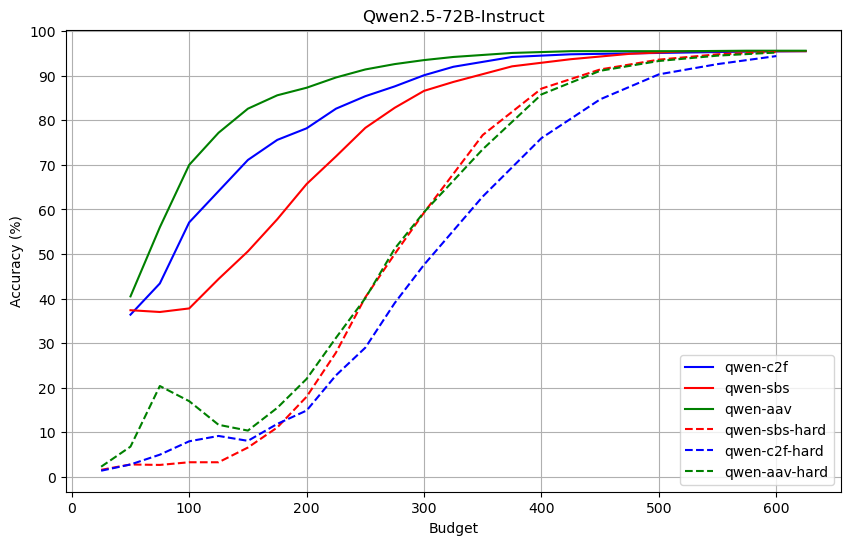

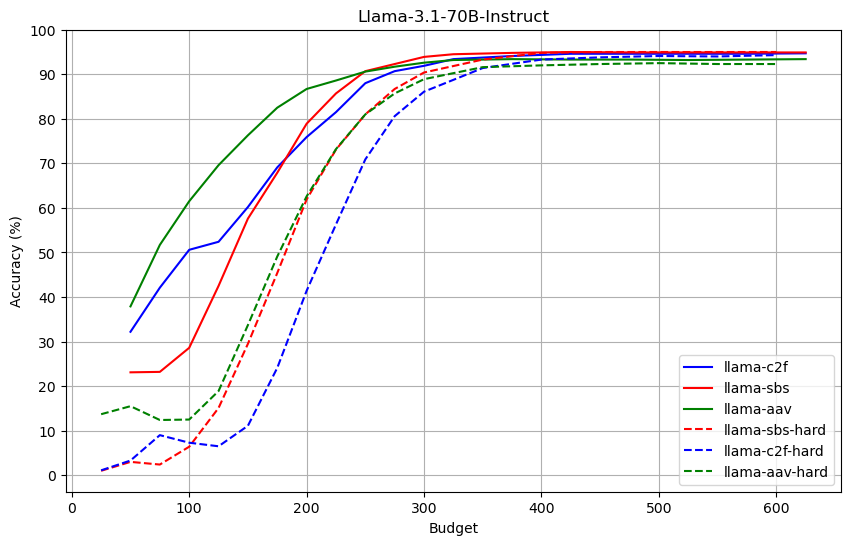

In [6]:
# plot separate image for each model
color_list = ["red", "blue", "green"]      

for model in model_list:
    plt.figure(figsize=(10, 6))
    for prompt_type in MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]:
        budget_list = gen_budget_list(1, dataset, model)
        if "hard" not in prompt_type:
            budget_list = [budget + 25 for budget in budget_list]
        linestyle = "--" if "hard" in prompt_type else "-"
        if "sbs" in prompt_type:
            plt.plot(budget_list, model_acc_dicts[model][prompt_type], label=prompt_type, linestyle=linestyle, linewidth=1.5, color=color_list[0])
        elif "c2f" in prompt_type:
            plt.plot(budget_list, model_acc_dicts[model][prompt_type], label=prompt_type, linestyle=linestyle, linewidth=1.5, color=color_list[1])
        elif "aav" in prompt_type:
            plt.plot(budget_list, model_acc_dicts[model][prompt_type], label=prompt_type, linestyle=linestyle, linewidth=1.5, color=color_list[2])
    plt.legend(loc="lower right")
    plt.title(model.split("/")[-1])
    plt.yticks(range(0, 101, 10))
    plt.grid(True)
    plt.xlabel("Budget")
    plt.ylabel("Accuracy (%)")
    plt.show()


In [7]:
dataset = "math500"
something = "_-1_seed0_t0.0_s0_e-1"

In [8]:
model_acc_dicts = {}
prompt_acc_dicts = {}

for model in model_list:
    model_acc_dict = {}
    budget_list = gen_budget_list(1, dataset, model)
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
    model_acc_dicts[model] = model_acc_dict

display(model_acc_dicts)

{'Qwen/Qwen2.5-72B-Instruct': {'qwen-c2f': [40.0,
   42.2,
   43.2,
   45.0,
   48.8,
   49.4,
   51.8,
   54.0,
   55.2,
   59.0,
   60.0,
   61.4,
   63.8,
   66.8,
   68.2,
   71.2,
   72.4,
   74.8,
   77.0,
   78.6,
   78.6,
   79.6,
   80.2,
   80.4],
  'qwen-sbs': [41.4,
   43.0,
   41.6,
   44.0,
   43.4,
   44.2,
   45.4,
   48.8,
   49.8,
   53.2,
   54.4,
   56.8,
   60.4,
   62.8,
   66.8,
   68.4,
   70.4,
   73.0,
   76.0,
   78.0,
   80.6,
   80.4,
   81.4,
   81.8],
  'qwen-aav': [39.8,
   40.8,
   44.8,
   48.4,
   50.6,
   54.0,
   54.6,
   58.0,
   59.4,
   62.2,
   63.4,
   64.0,
   66.0,
   67.8,
   69.8,
   71.2,
   73.6,
   74.0,
   76.4,
   77.6,
   79.4,
   79.6,
   79.4,
   79.4],
  'qwen-sbs-hard': [2.8,
   2.6,
   4.8,
   3.4,
   3.8,
   4.6,
   3.2,
   8.2,
   7.6,
   11.4,
   15.2,
   17.0,
   27.4,
   35.4,
   40.0,
   48.6,
   55.2,
   58.6,
   64.8,
   71.0,
   75.6,
   77.6,
   79.0,
   80.4],
  'qwen-c2f-hard': [1.4,
   4.0,
   3.6,
   3.4,
   5.6,
  

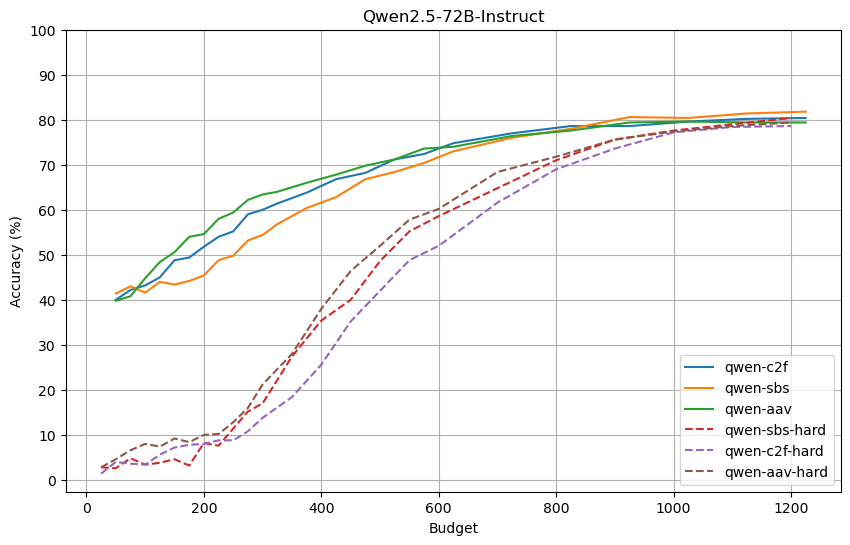

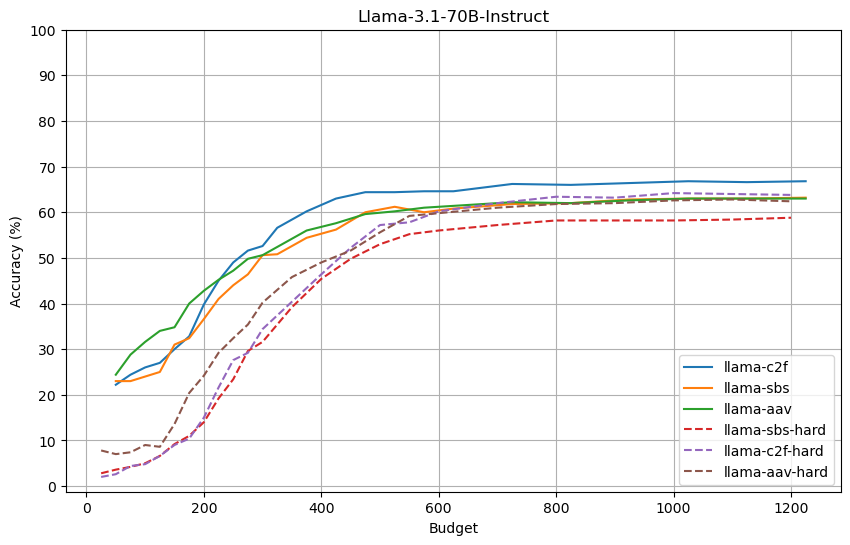

In [9]:
# plot separate image for each model
for model in model_list:
    plt.figure(figsize=(10, 6))
    for prompt_type in MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]:
        budget_list = gen_budget_list(1, dataset, model)
        if "hard" not in prompt_type:
            budget_list = [budget + 25 for budget in budget_list]
        linestyle = "--" if "hard" in prompt_type else "-"
        plt.plot(budget_list, model_acc_dicts[model][prompt_type], label=prompt_type, linestyle=linestyle, linewidth=1.5)
    plt.legend(loc="lower right")
    plt.title(model.split("/")[-1])
    plt.yticks(range(0, 101, 10))
    plt.grid(True)
    plt.xlabel("Budget")
    plt.ylabel("Accuracy (%)")
    plt.show()
